In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Attention, Input
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

Epoch 1/500


<ipython-input-6-1764c1efdf45>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv("/content/DataFrame.csv",parse_dates=["Timestamp"],index_col=[0])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0084 - val_loss: 0.0244
Epoch 2/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0132
Epoch 3/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 0.0102
Epoch 4/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0077
Epoch 5/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 6/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2013e-04 - val_loss: 0.0042
Epoch 7/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3680e-04 - val_loss: 0.0030
Epoch 8/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8344e-04 - val_loss: 0.0023
Epoch 9/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0479e-04 - val_loss: 0.0015
Epoch 10/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4893e-04 - val_loss: 9.9034e-04
Epoch 11/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7438e-04 - val_loss: 6.7673e-04
Epoch 12/500
167/167

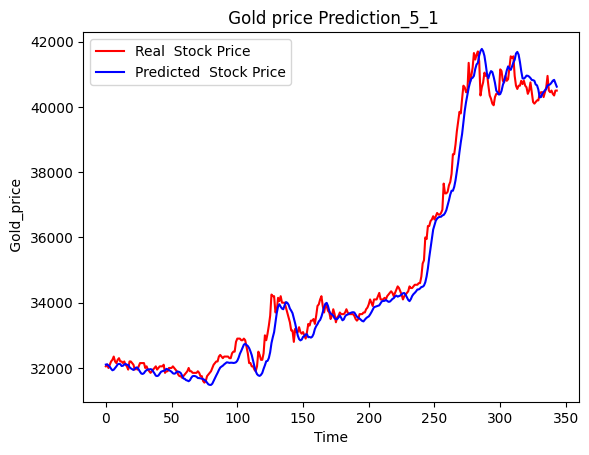

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


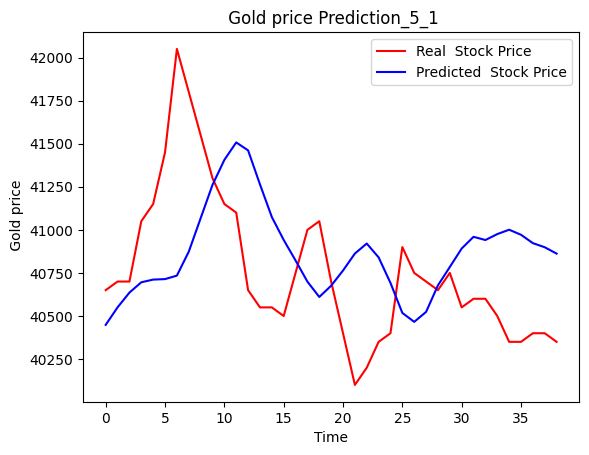

บันทึกค่าที่ทำนายและค่าจริงลงใน CSV เรียบร้อยแล้ว


In [6]:

indexfut=1#จำนวนวันล่วงหน้าที่ทำนาย
indexSeq=5#จำนวนข้อมูลย้อนหลัง
df=pd.read_csv("/content/DataFrame.csv",parse_dates=["Timestamp"],index_col=[0])
df1=pd.read_csv("/content/Test_data_sort.csv",parse_dates=["Timestamp"],index_col=[0])
    # print(df.index.freq)
    # เก็บค่า index ที่เป็นวันที่ก่อน reset index
original_index = df.index.copy()
df = df.iloc[350:]
    # รีเซ็ต index โดยไม่เก็บค่า index เดิมไว้
df = df.reset_index(drop=True)
    # df = df.drop(columns=['Policy_rate'])
    # df = df.drop(columns=['price_index'])
df1 = df1.drop(columns=['price_index'])
df1_cleaned = df1.replace(',', '', regex=True).astype(float)
scaler = MinMaxScaler(feature_range=(0,0.4))
df_scaled = scaler.fit_transform(df)

df_for_preTrain=df_scaled[:-350]
df_for_testing=df_scaled[-350:]

df_for_training=df_for_preTrain[:-350]
df_for_validation=df_for_preTrain[-350:]

def createXY(dataset, n_past, future):
  dataX = []
  dataY = []
  for i in range(n_past, len(dataset) - future):
      dataX.append(dataset[i - n_past:i,:])  # ดึงทุกฟีเจอร์ (ทุกคอลัมน์)
      dataY.append(dataset[i+future, 0])  # ทำนายเฉพาะคอลัมน์ 0 (หรือหลายคอลัมน์หากต้องการ)
  return np.array(dataX), np.array(dataY)

trainX,trainY=createXY(df_for_training,indexSeq,indexfut)
validateX,validateY=createXY(df_for_validation,indexSeq,indexfut)
testX,testY=createXY(df_for_testing,indexSeq,indexfut)
early_stop = EarlyStopping(
monitor='val_loss',     # ใช้ val_loss ในการตรวจสอบ
patience=10,             # หยุดการเทรนเมื่อไม่มีการปรับปรุงหลังจาก 5 epochs
mode='min',             # ต้องการค่าน้อยที่สุดเมื่อใช้กับ loss
restore_best_weights=True  # คืนค่าน้ำหนักของโมเดลให้เป็นค่าใน epoch ที่ดีที่สุด
),
ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)
    # สร้างโมเดล LSTM
model = Sequential()
model.add(LSTM(75, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.00002)
model.compile(optimizer=optimizer, loss='mean_squared_error',)

    # เทรนโมเดล
model.fit(trainX, trainY, epochs=500, batch_size=14, validation_data=(validateX, validateY),callbacks=[early_stop])

    # ทำการทำนาย
prediction=model.predict(testX)

    # แปลงผลการทำนายและค่าจริงกลับไปเป็นค่าเดิม (inverse scaling)
reshaped_predict = np.tile(prediction.reshape(-1, 1), df_for_testing.shape[1])
reshaped_actual = np.tile(testY.reshape(-1, 1), df_for_testing.shape[1])
predict_inver=scaler.inverse_transform(reshaped_predict)
actual_inver=scaler.inverse_transform(reshaped_actual)
predict_ori = predict_inver[:, 0].reshape(predict_inver.shape[0], 1)
actual_ori = actual_inver[:, 0].reshape(actual_inver.shape[0], 1)

    # แสดงผล

plt.plot(actual_ori, color = 'red', label = 'Real  Stock Price')
plt.plot(predict_ori, color = 'blue', label = 'Predicted  Stock Price')
plt.title(f' Gold price Prediction_{indexSeq}_{indexfut}')
plt.xlabel('Time')
plt.ylabel(' Gold_price')
plt.legend()
plt.show()

new_scaler=scaler
df1_scaled = new_scaler.fit_transform(df1_cleaned)

test1X,test1Y=createXY(df1_scaled,indexSeq,indexfut)
prediction_new=model.predict(test1X)
re_predict = np.tile(prediction_new.reshape(-1, 1),df1_scaled.shape[1])
re_actual = np.tile(test1Y.reshape(-1, 1), df1_scaled.shape[1])
predict_invert=scaler.inverse_transform(re_predict)
actual_invert=scaler.inverse_transform(re_actual)
predict_ori1 = predict_invert[:, 0].reshape(predict_invert.shape[0], 1)
actual_ori1 = actual_invert[:, 0].reshape(actual_invert.shape[0], 1)

plt.plot(actual_ori1, color = 'red', label = 'Real  Stock Price')
plt.plot(predict_ori1, color = 'blue', label = 'Predicted  Stock Price')
plt.title(f' Gold price Prediction_{indexSeq}_{indexfut}')
plt.xlabel('Time')
plt.ylabel(' Gold price')
plt.legend()
plt.show()

spli=df.shape[0]
df = df.reset_index(drop=True)
    # เพิ่มคอลัมน์ 'Timestamp' ด้วยค่า original_index หลังลบ 350 แถว
df['Timestamp'] = original_index[350:]
    # ตั้งค่า 'Timestamp' เป็น index ใหม่
df.set_index('Timestamp', inplace=True)
df = df.reset_index(drop=True)
    # เพิ่มคอลัมน์ 'Timestamp' ด้วยค่า original_index หลังลบ 350 แถว
df['Timestamp'] = original_index[350:]

predicted_dates = df.Timestamp[spli-350 + indexSeq+indexfut:]
comparison_df = pd.DataFrame({
        'Date': predicted_dates,            # วันที่ที่ตรงกับค่าทำนาย
        'Real Gold Price': actual_ori.reshape(-1),  # ค่าจริง (แปลง Y_test กลับมาอยู่ในรูปแบบดั้งเดิมได้ถ้าต้องใช้ scaler.inverse_transform)
        f'Predicted Gold Price single_{indexSeq}_{indexfut}': predict_ori.reshape(-1)  # ค่าที่ทำนายได้
})

    # บันทึกเป็นไฟล์ CSV
comparison_df.to_csv(f'gold_price_single_{indexSeq}_{indexfut}.csv', index=False)
print("บันทึกค่าที่ทำนายและค่าจริงลงใน CSV เรียบร้อยแล้ว")